<a href="https://colab.research.google.com/github/codeyumm/adl-midterm-project/blob/main/Group_02_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# libs
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

In [37]:
# set random seed for reproducibility
np.random.seed(66)

torch.manual_seed(66)

# select deive, CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using", device, "for computation.")

Using cpu for computation.


In [3]:
# get the dataset
train_data = datasets.KMNIST(root="./data", train=True, download=True)

100%|██████████| 18.2M/18.2M [00:05<00:00, 3.23MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 768kB/s]
100%|██████████| 3.04M/3.04M [00:00<00:00, 5.03MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.62MB/s]


### Observing the dataset

In [9]:
# shape of dataset
print(f"Number of training samples : {len(train_data)}")

Number of training samples : 60000


In [21]:
# display sample image from the test dataset
image, label = train_data[6]

# size of image
print(f"Size of image is : {image.size}")

Size of image is : (28, 28)


### We can see that we have 28 x 28 image and it is a grayscale as there is only one color channel

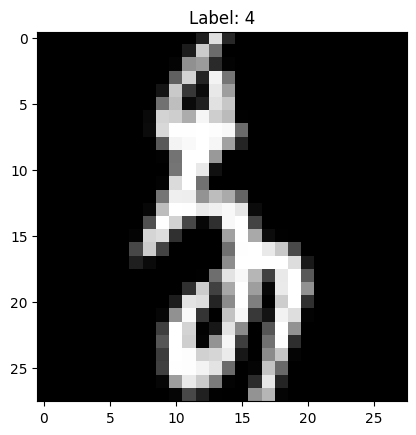

In [19]:
# sample image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

### Now we need to normalize the dataset for better computation and also we need to convert it to tensors becasue our deep learning models works with tensors

In [22]:
# load the dataset
train_data = datasets.KMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())


data_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)

# get all pixel values
data = next(iter(data_loader))[0]
mean = data.mean()
std = data.std()

print(f"Mean of train dataset : {mean}")
print(f"STD of train dataset : {std}")


Mean of train dataset : 0.19176216423511505
STD of train dataset : 0.3483428359031677


In [24]:
# transforms object
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# load the dataset with transforms object to get the normalize data

train_data = datasets.KMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.KMNIST(root="./data", train=False, download=True, transform=transform)


# shape of dataset
print(f"Number of training samples : {len(train_data)}")
print(f"Number of testing samples : {len(test_data)}")

Number of training samples : 60000
Number of testing samples : 10000


### At this point, our input is standardize in terms of we have normalized it wiht mean and std. Now all the pixels are in range of [-1, 1] and most of them should be centerd around 0

### Defining the model architecture

In [26]:
# model network

class Kmnist_Net(nn.Module):
  def __init__(self):
    super(Kmnist_Net, self).__init__()

    # convert 2d (28 * 28) to 1d 784)

    self.flatten = nn.Flatten()

    # first fully connected layer input(784) to hidden 1 (128)
    self.fc1 = nn.Linear(784, 128)

    # second fully connected layer input(128) to hidden 2 (64)
    self.fc2 = nn.Linear(128, 64)

    # third fully connected layer input(64) to output (10)
    self.fc3 = nn.Linear(64, 10)

    # activation function - for hidden layers - ReLu
    self.relu = nn.ReLU()

    # activation fucntion - for output layer - SoftMax

    # self.soft_max = nn.Softmax()
    # we dont need to add this here because crossentropyloss,
    # expects raw logits as input and it applies logsoftmax


  # forward pass
  def forward(self, input):

    # 2d to 1d
    x = self.flatten(input)

    # pass it to fc1 with ReLu activation
    x = self.fc1(x)
    x = self.relu(x)

    # pass it to fc2 with ReLu activation
    x = self.fc2(x)
    x = self.relu(x)

    # pass it to fc3 with Softmax activation
    x = self.fc3(x)
    # x = self.soft_max(x)

    return x








### In above model we are not adding softmax activation function becasue, CrossEntropyLoss computes the cross entropy loss between input logits and target and it also applies  LogSoftmax internally

### Source - [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

### Defining Inital Hyperparameters

In [28]:
# how fast we want to move on gradient to find minima
learning_rate = 0.001

# number of time we want to go thorugh whole dataset
epochs = 50

# number of samples the model sees before updating weights
batch_size = 64

# define loss function - CrossEntropyLoss()
loss_function = nn.CrossEntropyLoss()

In [30]:
# data loader object to get data into batch
# shuffle True for tranloader becasue it prevents model to remeber the pattern of data
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

test_loader = DataLoader(test_data, batch_size= 1000, shuffle=False)

### Traning Loooooop

In [52]:
def train(loss_function, optimizer = None):

  # move model to gpu
  model = Kmnist_Net().to(device)

  # set model to train
  model.train()



  for epoch in range(epochs):

    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      # get the output
      output = model(images)

      # find the loss
      loss = loss_function(output, labels)

      # backpropogate to find optimal weights
      loss.backward()

      # update weight
      optimizer.step()

      # calculate the loss
      running_loss += loss.item()

      # find correct output
      _, predicted = torch.max(output, 1)

      correct += (predicted == labels).sum().item()

      # total images seen by model
      total += labels.size(0)

    train_acc = ( correct / total ) * 100
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss:.4f},  Train Accuracy : {train_acc:.2f}%")



### Evaluation Loop

In [53]:
def Evaluate(model):

  correct = 0
  total = 0

  # set model to eval mode
  model.eval()

  # disavle gradient calculations
  torch.no_grad()
  with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        # get the output
        output = model(images)

        # get the predicted labels
        _, predicted = torch.max(output, 1)

        # total number of images
        total += labels.size(0)

        # count correct predictions
        correct += (predicted == labels).sum().item()


  test_accuracy = 100 * (correct / total)
  print(f"Test Accuracy: {test_accuracy:.2f}%")





